In [1]:
import pickle
from tqdm.auto import tqdm
import numpy as np

from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import torch
import torch.nn.functional as F
from torch.optim import Adam

import matplotlib.pyplot as plt

import INN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
train_dataset = datasets.MNIST(root='../mnist_data/', train=True, download=False)
test_dataset = datasets.MNIST(root='../mnist_data/', train=False, download=False)

In [4]:
X_train = train_dataset.data.view(-1, 28*28)
X_test = test_dataset.data.view(-1, 28*28)

y_train = train_dataset.targets
y_test = test_dataset.targets

In [5]:
sc_X_train = StandardScaler()
X_train_scaled = torch.Tensor(sc_X_train.fit_transform(X_train)).to(device)
X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

y_train = F.one_hot(y_train).to(device).type(torch.float32)
y_test = F.one_hot(y_test)

In [7]:
loss_weights = {
    'dvg_factor': 1,
    'logdet_factor': 1,
    'rcst_factor': 10
}

In [8]:
batch_size = 64
n_epochs = 16

In [9]:
cinn = INN.CINN(X_train_scaled.size(1), y_train.size(1), n_blocks=5, coupling_network_layers=[512] * 2, device=device).to(device)

In [10]:
loss_history = cinn.fit(X_train_scaled, y_train, n_epochs=n_epochs, batch_size=batch_size, optimizer=Adam(cinn.parameters(), lr=1e-4), loss_weights=loss_weights, verbose=2)

Epoch 15: 100%|██████████| 937/937 [00:30<00:00, 30.40it/s, batch=936/937, weighted_loss=-1039.294, dvg=+379.421, rcst=+0.351, logdet=-1422.222]


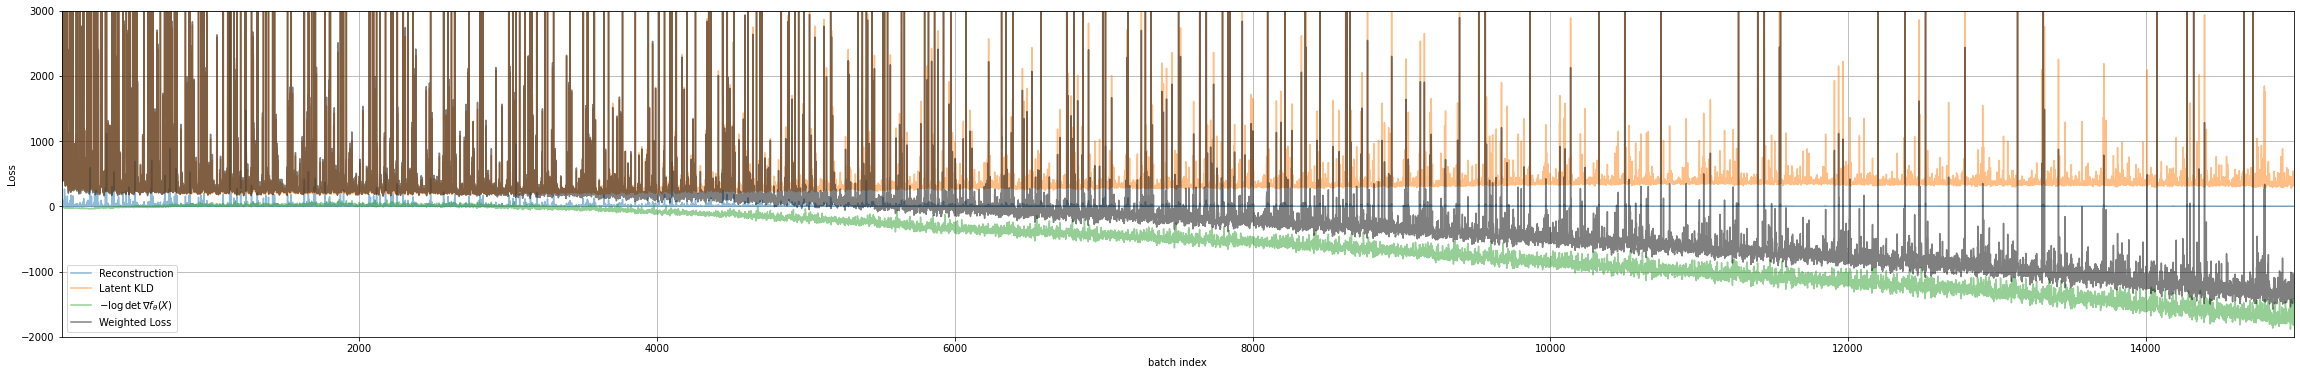

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(40, 6))

ax.plot(loss_history['rcst'], label='Reconstruction', alpha=0.5)
ax.plot(loss_history['dvg'], label='Latent KLD', alpha=0.5)
ax.plot(loss_history['logdet'], label=r'$-\log \det \nabla f_{\theta}(X)$', alpha=0.5)
ax.plot(loss_history['weighted_loss'], label='Weighted Loss', color='black', alpha=0.5)

ax.set_xlim(1, 1+len(loss_history['rcst'])); ax.set_ylim(-2000, 3000); 
ax.set_xlabel('batch index'); ax.set_ylabel('Loss'); ax.grid()
ax.legend();

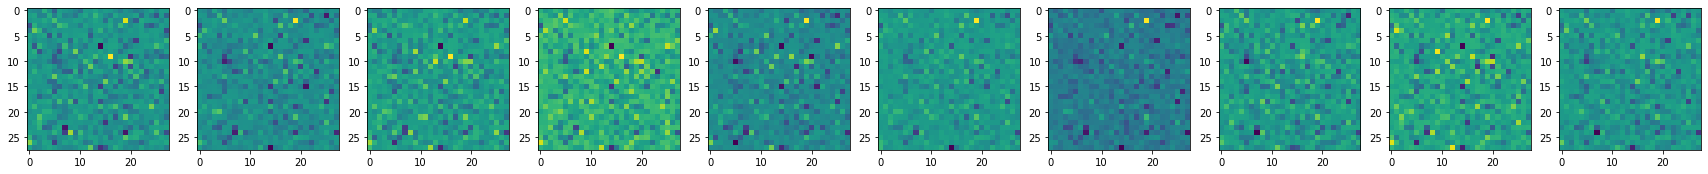

In [18]:
y_sample = F.one_hot(torch.arange(10)).to(device)
z_sample = torch.zeros((y_sample.size(0), 28*28)).to(device)

x_rec = cinn.inverse(z_sample, y_sample).detach().cpu().numpy()

fig, ax = plt.subplots(1, 10, figsize=(30, 6))
for i in range(10):
    ax[i].imshow(x_rec[i].reshape(28, 28))